In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For Bayesian Networks
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# For machine learning models
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

c:\Users\abhis\OneDrive\Desktop\AML\task1\task1\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Step 1: Load the dataset from UCI repository
# URL of the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'


In [4]:
# Column names as per the dataset's documentation
column_names = [
    'age',       # age in years
    'sex',       # sex (1 = male; 0 = female)
    'cp',        # chest pain type (1-4)
    'trestbps',  # resting blood pressure (in mm Hg)
    'chol',      # serum cholesterol in mg/dl
    'fbs',       # fasting blood sugar > 120 mg/dl (1 = true; 0 = false)
    'restecg',   # resting electrocardiographic results (0-2)
    'thalach',   # maximum heart rate achieved
    'exang',     # exercise-induced angina (1 = yes; 0 = no)
    'oldpeak',   # ST depression induced by exercise relative to rest
    'slope',     # the slope of the peak exercise ST segment (1-3)
    'ca',        # number of major vessels (0-3) colored by fluoroscopy
    'thal',      # 3 = normal; 6 = fixed defect; 7 = reversible defect
    'target'     # diagnosis of heart disease (0 = no disease, 1-4 = disease)
]

In [5]:
# Read the dataset
data = pd.read_csv(url, names=column_names)

In [6]:
# Replace missing values denoted by '?' with NaN
data.replace('?', np.nan, inplace=True)

In [7]:
# Display the first few rows
print("First 5 rows of the dataset:")
print(data.head())

First 5 rows of the dataset:
    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   slope   ca thal  target  
0    3.0  0.0  6.0       0  
1    2.0  3.0  3.0       2  
2    2.0  2.0  7.0       1  
3    3.0  0.0  3.0       0  
4    1.0  0.0  3.0       0  


In [9]:
# Step 2: Data Preprocessing

# 1. Handling Missing Data
print("\nNumber of missing values in each column:")
print(data.isnull().sum())


Number of missing values in each column:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
target      0
dtype: int64


In [10]:
# Convert columns to numeric, coercing errors to NaN
for col in ['ca', 'thal']:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [11]:
# Impute missing values with the median for numerical columns
data.fillna(data.median(), inplace=True)


In [12]:
print("\nNumber of missing values after imputation:")
print(data.isnull().sum())


Number of missing values after imputation:
age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [13]:
# Define the number of bins for discretization
n_bins = 3  # low, medium, high

In [14]:
# List of continuous columns to discretize
continuous_columns = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [15]:
# Initialize the discretizer
est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')

In [16]:
# Fit and transform the data
data[continuous_columns] = est.fit_transform(data[continuous_columns])

In [17]:
# 3. Feature Selection
# Select 8 relevant features
selected_features = ['age', 'sex', 'cp', 'trestbps', 'chol', 
                     'fbs', 'thalach', 'exang', 'target']

data = data[selected_features]

In [18]:
# Re-encode the target variable: 0 (no disease), 1 (disease)
data['target'] = data['target'].apply(lambda x: 1 if x > 0 else 0)

In [19]:
# Display the dataset after preprocessing
print("\nDataset after preprocessing:")
print(data.head())


Dataset after preprocessing:
   age  sex   cp  trestbps  chol  fbs  thalach  exang  target
0  2.0  1.0  1.0       1.0   0.0  1.0      1.0    0.0       0
1  2.0  1.0  4.0       1.0   1.0  0.0      0.0    1.0       1
2  2.0  1.0  4.0       0.0   0.0  0.0      1.0    1.0       1
3  0.0  1.0  3.0       1.0   0.0  0.0      2.0    0.0       0
4  0.0  0.0  2.0       1.0   0.0  0.0      2.0    0.0       0


In [20]:
# Step 3: Model Construction – Bayesian Network

# 1. Define the structure of the Bayesian Network
model = BayesianModel([
    ('age', 'trestbps'),
    ('age', 'chol'),
    ('sex', 'chol'),
    ('chol', 'target'),
    ('trestbps', 'target'),
    ('thalach', 'target'),
    ('exang', 'thalach'),
    ('fbs', 'chol'),
    ('cp', 'target'),
    ('sex', 'exang'),
    ('sex', 'cp')
])

In [21]:
# 2. Parameter Learning
# Fit the model to the data
model.fit(data, estimator=MaximumLikelihoodEstimator)

In [23]:
# 3. Inference
inference = VariableElimination(model)


In [24]:
# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

In [25]:
# Step 4: Model Evaluation

# Split the data into training and testing sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [26]:
# Get the ground truth
y_test = test_data['target'].values

In [27]:
# Remove 'target' from the test data
test_data = test_data.drop('target', axis=1)

In [28]:
# Predict using the Bayesian Network
y_pred = []
for _, row in test_data.iterrows():
    evidence = row.to_dict()
    query_result = inference.query(variables=['target'], evidence=evidence, show_progress=False)
    y_pred.append(int(query_result.values.argmax()))


In [29]:
# Calculate metrics
print("\nBayesian Network Performance:")
calculate_metrics(y_test, y_pred)


Bayesian Network Performance:
Accuracy: 0.8688524590163934
Precision: 0.9
Recall: 0.84375
F1 Score: 0.8709677419354839

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87        29
           1       0.90      0.84      0.87        32

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61



In [30]:
# Step 4 Continued: Compare with Logistic Regression and Decision Tree

# Prepare data for scikit-learn models
X = data.drop('target', axis=1)
y = data['target']


In [31]:
# Split data
X_train, X_test, y_train_lr, y_test_lr = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train_lr)
y_pred_lr = lr.predict(X_test)

In [33]:
print("\nLogistic Regression Performance:")
calculate_metrics(y_test_lr, y_pred_lr)


Logistic Regression Performance:
Accuracy: 0.8032786885245902
Precision: 0.8333333333333334
Recall: 0.78125
F1 Score: 0.8064516129032258

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        29
           1       0.83      0.78      0.81        32

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.81      0.80      0.80        61



In [34]:
# Decision Tree Classifier
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train_lr)
y_pred_dt = dt.predict(X_test)


In [35]:
print("\nDecision Tree Performance:")
calculate_metrics(y_test_lr, y_pred_dt)



Decision Tree Performance:
Accuracy: 0.7868852459016393
Precision: 0.7878787878787878
Recall: 0.8125
F1 Score: 0.8

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        29
           1       0.79      0.81      0.80        32

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.79      0.79      0.79        61



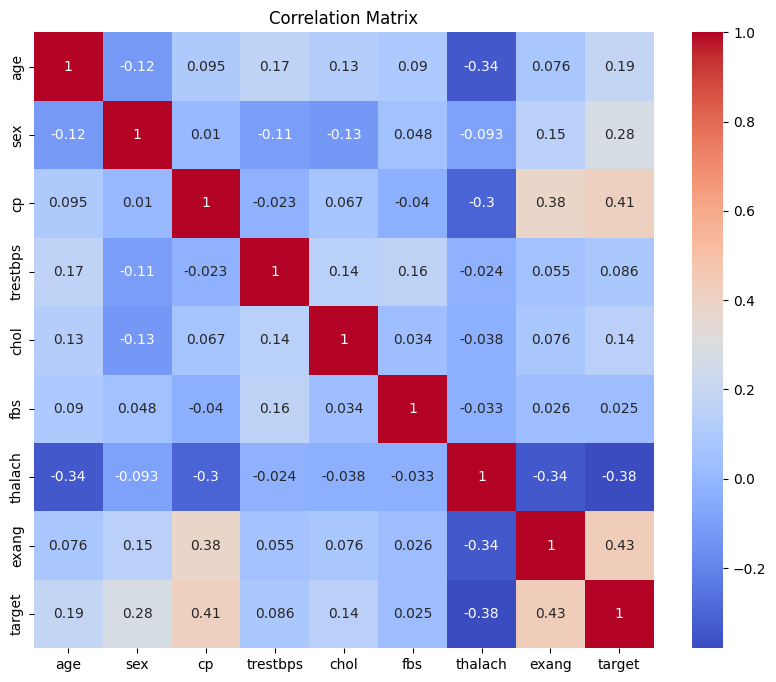

In [36]:
# Step 5: Visualization

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


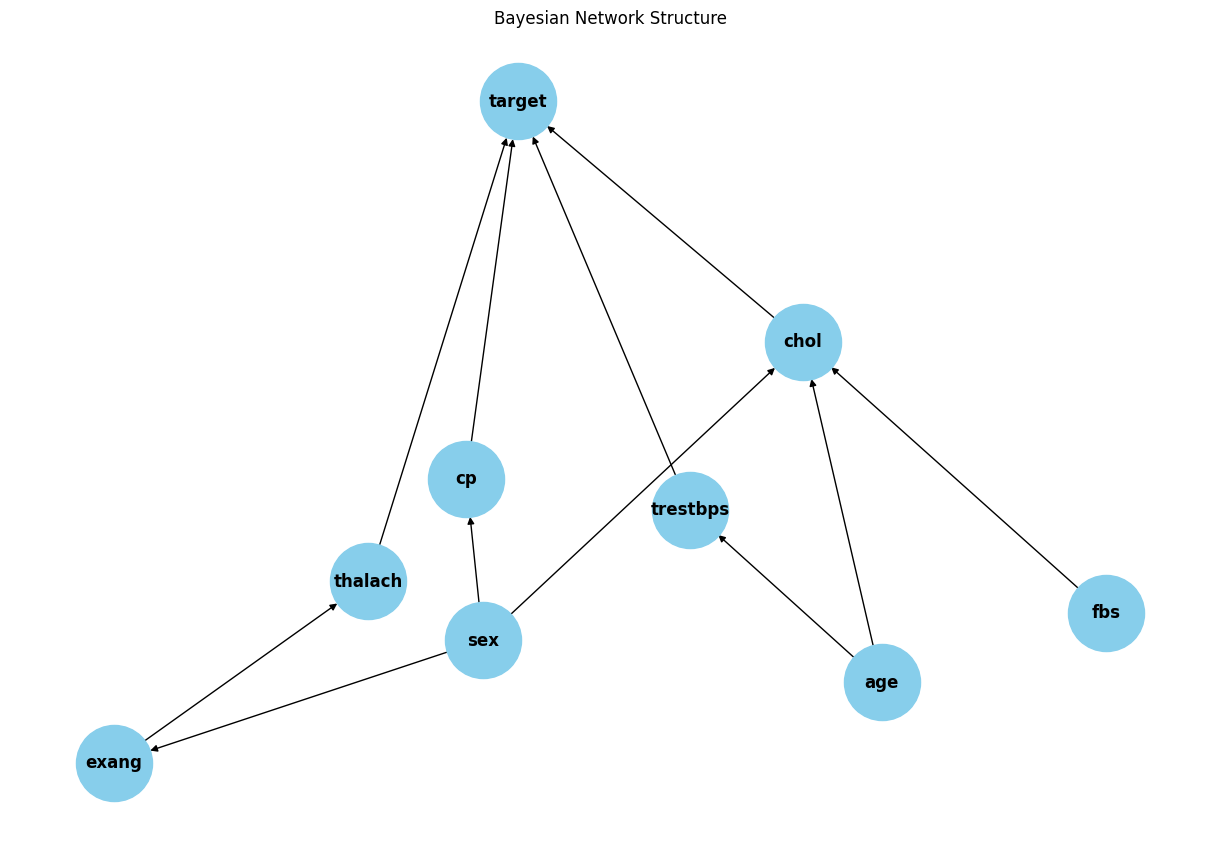

In [41]:
# Visualize the structure of the Bayesian Network
import networkx as nx

plt.figure(figsize=(12, 8))

# Create a new DiGraph
G = nx.DiGraph()
G.add_nodes_from(model.nodes())
G.add_edges_from(model.edges())

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold')
plt.title('Bayesian Network Structure')
plt.show()


In [39]:
# Ethical and Social Considerations
print("\nEthical Considerations:")
print("This model is trained on a dataset that may not represent all populations equally.")
print("Care should be taken when generalizing the results to different demographic groups.")
print("Explainability is crucial in medical applications to ensure trust and accountability.")


Ethical Considerations:
This model is trained on a dataset that may not represent all populations equally.
Care should be taken when generalizing the results to different demographic groups.
Explainability is crucial in medical applications to ensure trust and accountability.
